In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

## Regression Model ##

In [3]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

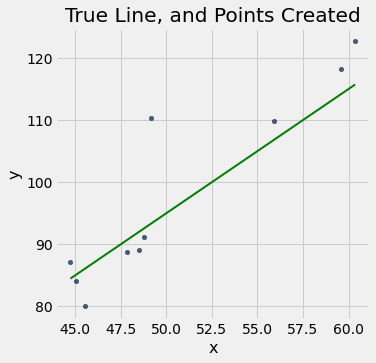

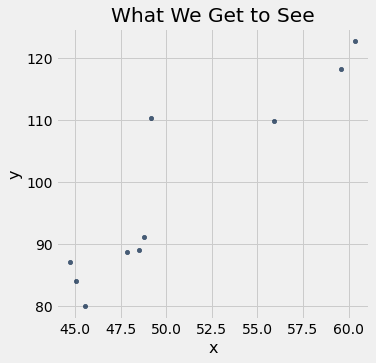

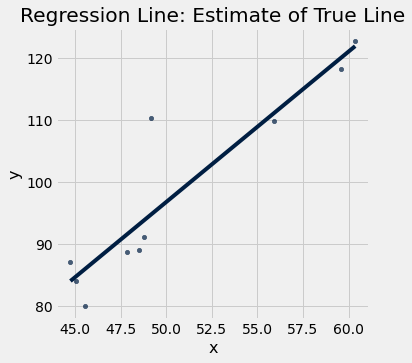

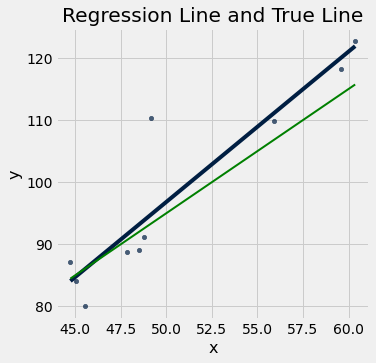

In [4]:
draw_and_compare(2, -5, 10)

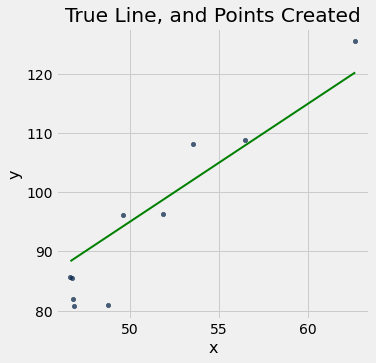

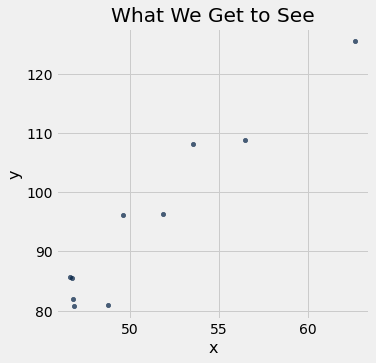

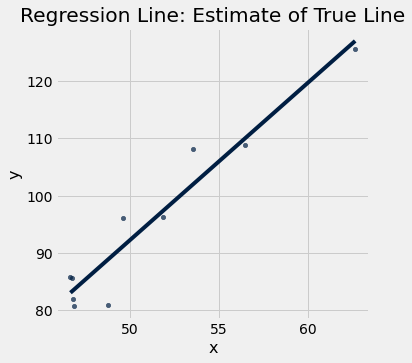

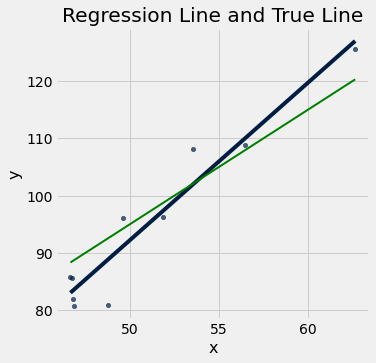

In [5]:
draw_and_compare(2, -5, 10)

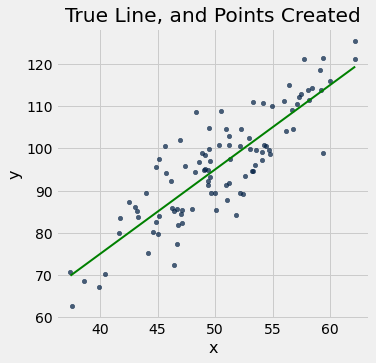

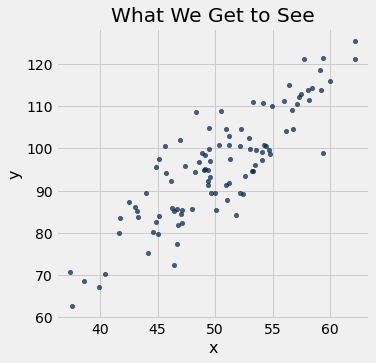

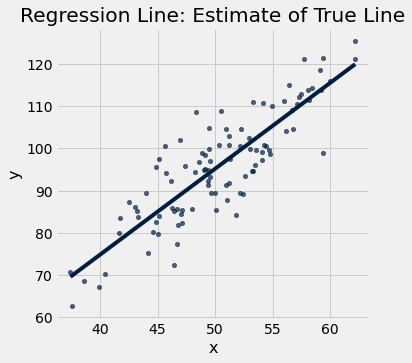

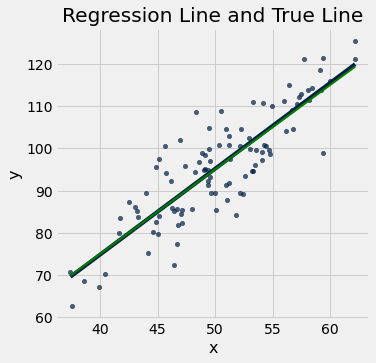

In [6]:
draw_and_compare(2, -5, 100)

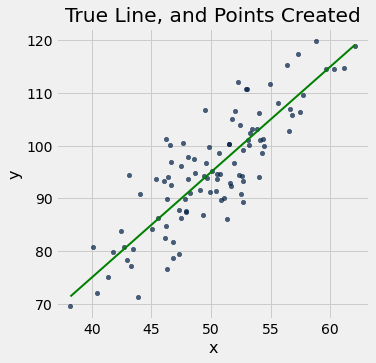

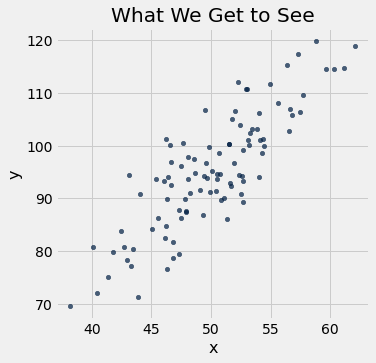

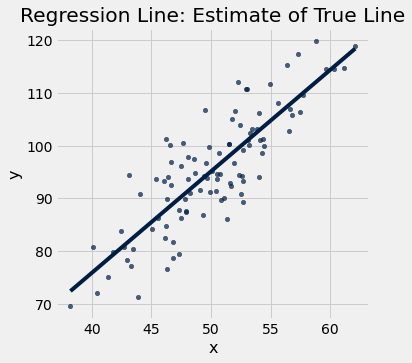

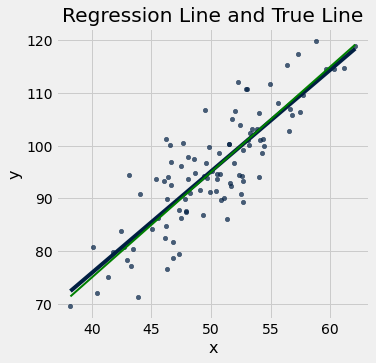

In [7]:
draw_and_compare(2, -5, 100)

## Prediction ##

In [9]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [ ]:
# Preterm and postterm pregnancy cutoffs, according to the CDC
37 * 7, 42 * 7

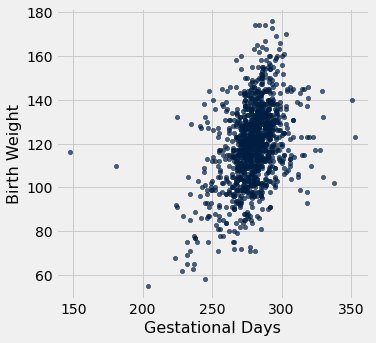

In [10]:
births.scatter('Gestational Days', 'Birth Weight')

In [11]:
births = births.where('Gestational Days', are.between(225, 325))

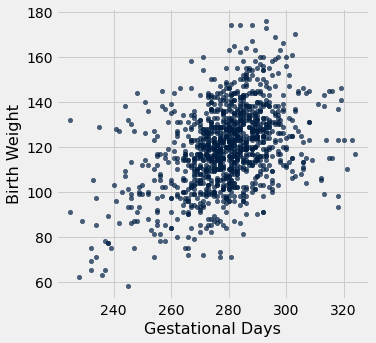

In [12]:
births.scatter('Gestational Days', 'Birth Weight')

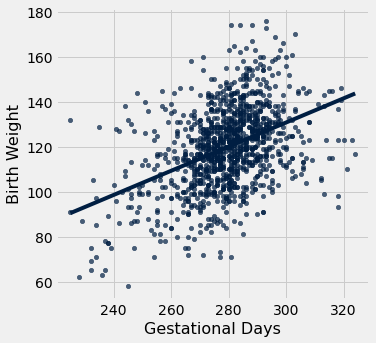

In [13]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [14]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.4229511845242399

In [15]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [16]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.8095167424877

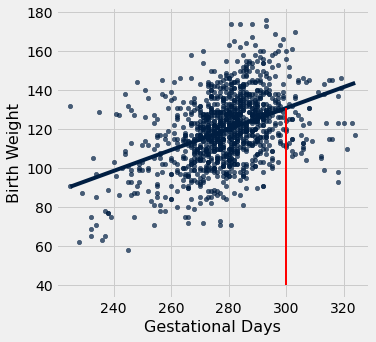

In [17]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2);

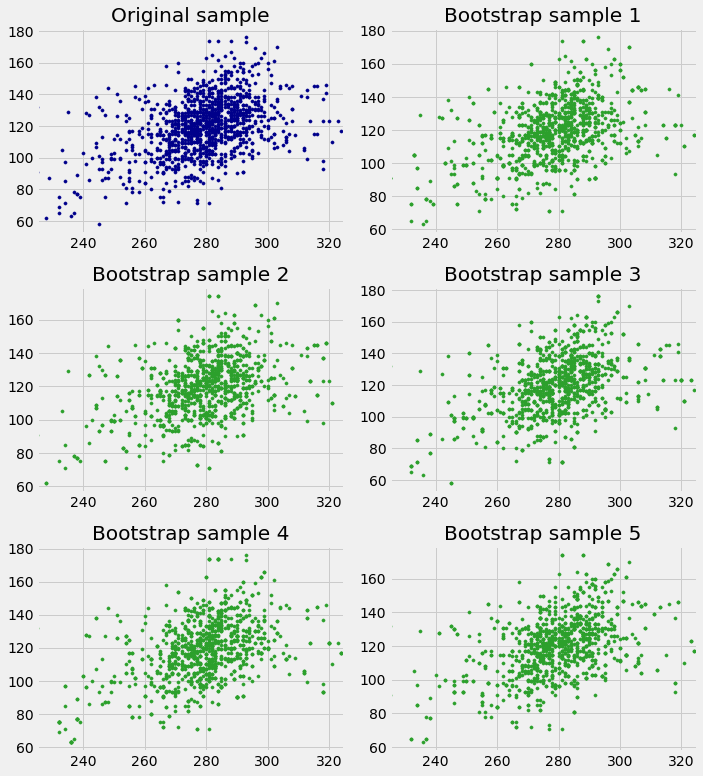

In [18]:
# You don't need to understand the plotting code in this cell,
# but you should understand the figure that comes out.

plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()

Predicted y from bootstramp sample was 132.43639917735172
Predicted y from bootstramp sample was 131.6089689033804
Predicted y from bootstramp sample was 131.47800743370055
Predicted y from bootstramp sample was 131.18740876973754


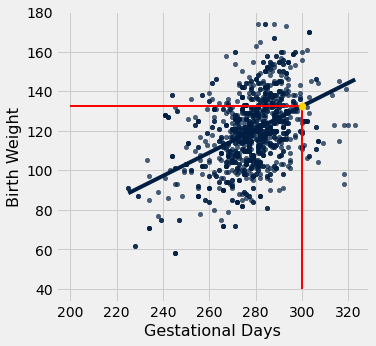

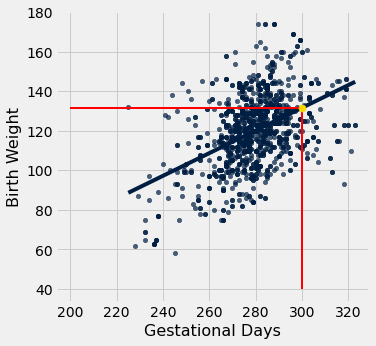

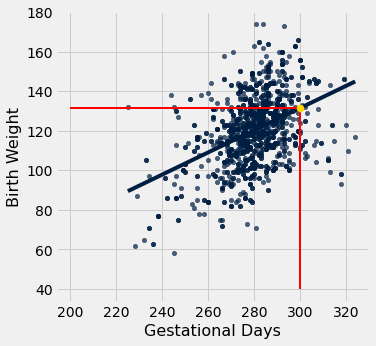

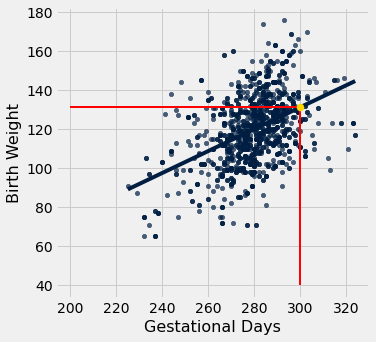

In [19]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='red', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='red', lw=2);

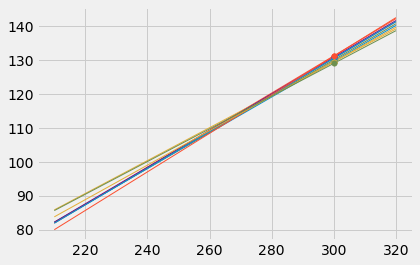

In [21]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

In [22]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
lines


slope,intercept,at 291,at 300,at 309
0.537992,-30.7698,125.786,130.628,135.47
0.573126,-40.1592,126.62,131.779,136.937
0.518847,-25.6431,125.341,130.011,134.681
0.638946,-58.8518,127.081,132.832,138.582
0.50707,-22.3871,125.17,129.734,134.297
0.561111,-36.9055,126.378,131.428,136.478
0.567424,-38.7638,126.357,131.463,136.57
0.581401,-42.8534,126.334,131.567,136.799
0.571414,-39.9574,126.324,131.467,136.609
0.578502,-40.3124,128.032,133.238,138.445


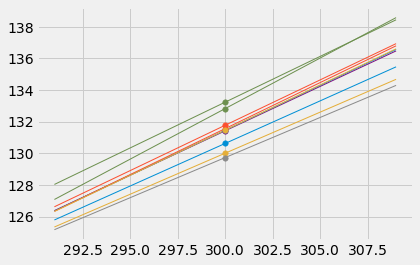

In [23]:
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Confidence Interval for Prediction ##

In [ ]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):
    """ 
    Makes a 95% confidence interval for the prediction at new_x, using
    linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

In [ ]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Inference for the Slope ##

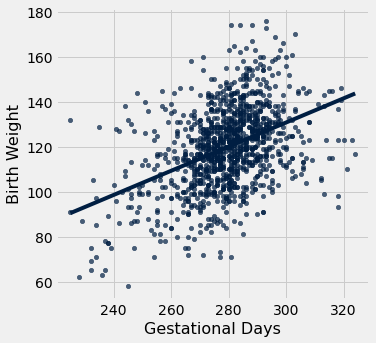

In [28]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [29]:
slope(births, 'Gestational Days', 'Birth Weight')

0.5378453676679036

In [30]:
def bootstrap_slope(t, x, y, repetitions=5000):
    """ 
    Makes a 95% confidence interval for the slope of the prediction line
    for y, using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

Slope of regression line: 0.5378453676679036
Approximate 95%-confidence interval for the slope of the true line:
0.4605420706594672 to 0.617299573157315


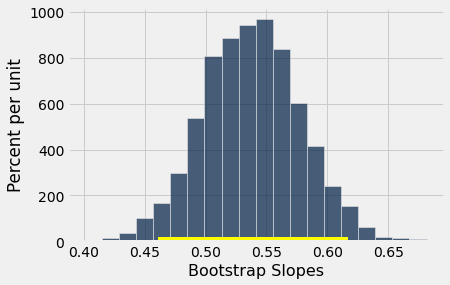

In [31]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 2500)

## Rain on the Regression Parade

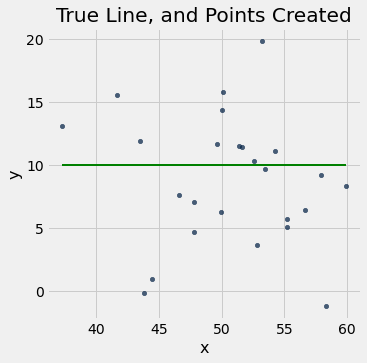

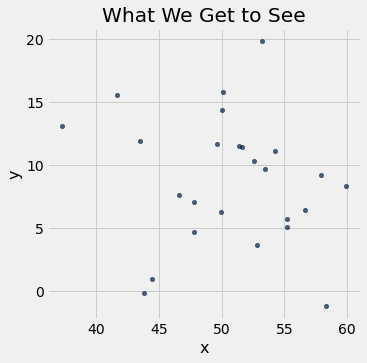

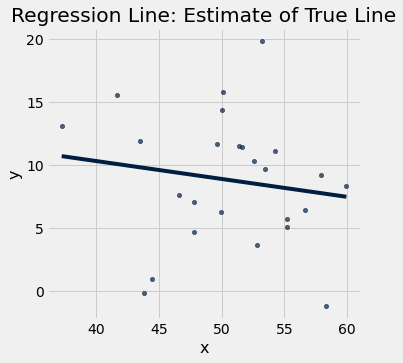

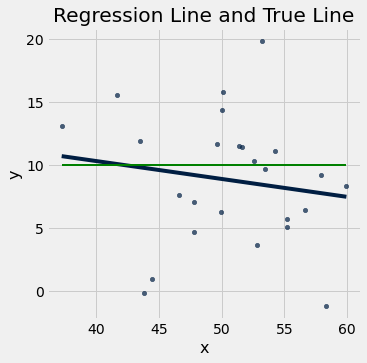

In [24]:
draw_and_compare(0, 10, 25)

### Testing whether the line is flat

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

In [25]:
slope(births, 'Maternal Age', 'Birth Weight')

0.09514223729834466

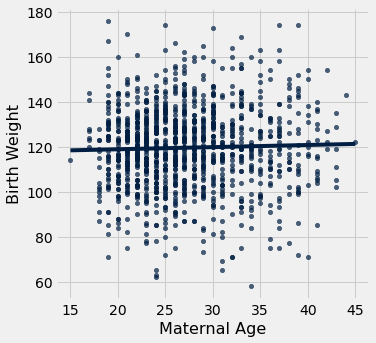

In [26]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

Slope of regression line: 0.09514223729834466
Approximate 95%-confidence interval for the slope of the true line:
-0.08622245763018231 to 0.2779315211074609


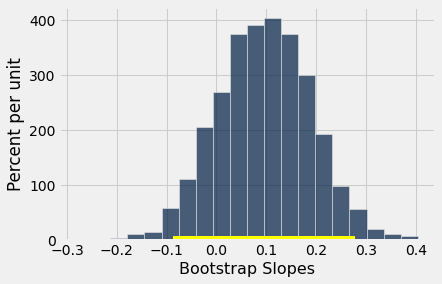

In [32]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 2500)

## Nonlinear regression

In [33]:
cars = Table.read_table('cars2016.csv')
cars = cars.select('name', 'city_mpg', 'highway_mpg', 'engine_torque')
cars.show(3)

name,city_mpg,highway_mpg,engine_torque
2009 Audi A3 3.2,18,25,236
2009 Audi A3 2.0 T AT,22,28,207
2009 Audi A3 2.0 T,21,30,207


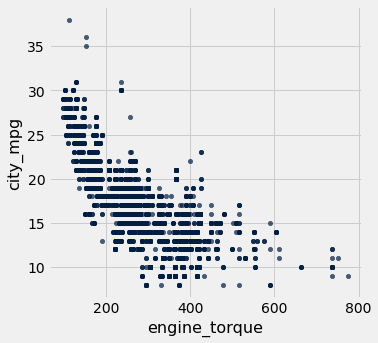

In [34]:
cars.scatter('engine_torque', 'city_mpg')

In [35]:
def compute_car_quadratic_mse(a, b, c):
    x = cars.column('engine_torque')
    y = cars.column('city_mpg')
    quadratic_prediction = a * x**2 + b * x + c
    quadratic_mse = np.mean((y - quadratic_prediction) ** 2)
    return np.sqrt(quadratic_mse)

In [36]:
result = minimize(compute_car_quadratic_mse)

In [37]:
a = result.item(0)
b = result.item(1)
c = result.item(2)
x = cars.column('engine_torque')
cars = cars.with_column(
    'Quadratic city mpg prediction', a * x**2 + b*x + c
)

In [38]:
compute_car_quadratic_mse(a,b,c)

2.5711890368590042

In [39]:
cars

name,city_mpg,highway_mpg,engine_torque,Quadratic city mpg prediction
2009 Audi A3 3.2,18,25,236,17.9559
2009 Audi A3 2.0 T AT,22,28,207,19.3885
2009 Audi A3 2.0 T,21,30,207,19.3885
2009 Audi A3 2.0 T Quattro,21,28,207,19.3885
2009 Audi A3 2.0 T Quattro,21,28,207,19.3885
2009 Audi A5 3.2,16,27,243,17.6331
2009 Audi A5 3.2 AT,17,26,243,17.6331
2009 Audi Q7 4.2,13,18,325,14.5154
2009 Audi Q7 3.6,14,20,266,16.6351
2009 Audi A4 Sedan 2.0 T Quattro,22,30,258,16.9713


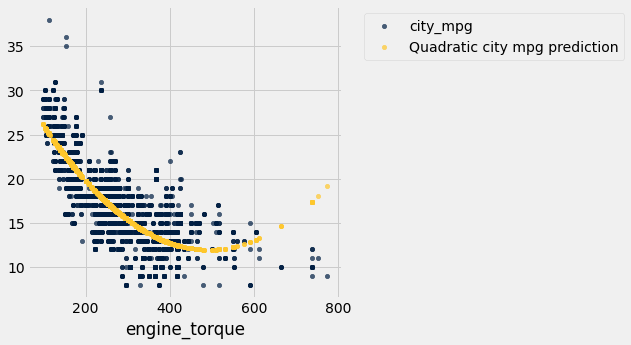

In [40]:
cars.select('engine_torque', 'city_mpg', 'Quadratic city mpg prediction').scatter('engine_torque')

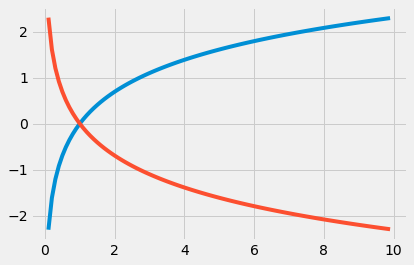

In [41]:
x_ = np.arange(.1, 10, .1)
y_ = np.log(x_)
plots.plot(x_, y_)
plots.plot(x_, -y_)

In [42]:
def compute_car_log_mse(a, b, c):
    x = cars.column('engine_torque')
    y = cars.column('city_mpg')
    log_prediction = a * np.log(b * x) + c
    log_mse = np.mean((y - log_prediction) ** 2)
    return np.sqrt(log_mse)

In [43]:
result = minimize(compute_car_log_mse)

/tmp/ipykernel_287646/289129203.py:4: RuntimeWarning: divide by zero encountered in log
  log_prediction = a * np.log(b * x) + c
/tmp/ipykernel_287646/289129203.py:4: RuntimeWarning: invalid value encountered in multiply
  log_prediction = a * np.log(b * x) + c
/home/shaolin/Documents/Teaching/2022/cs2065/virtual-env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/shaolin/Documents/Teaching/2022/cs2065/virtual-env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/shaolin/Documents/Teaching/2022/cs2065/virtual-env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


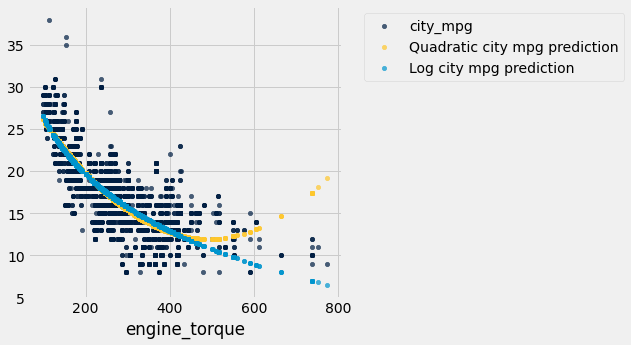

In [44]:
a = result.item(0)
b = result.item(1)
c = result.item(2)
x = cars.column('engine_torque')
cars = cars.with_column(
    'Log city mpg prediction', a * np.log(b*x) + c
)
cars.select(
    'engine_torque', 'city_mpg', 'Quadratic city mpg prediction', 'Log city mpg prediction'
).scatter('engine_torque')

In [45]:
compute_car_log_mse(a,b,c)

2.5874255279605682

## Multiple regression

In [46]:
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [47]:
correlation(births, 'Birth Weight', 'Gestational Days')

0.4229511845242399

In [48]:
correlation(births, 'Birth Weight', 'Maternal Age')

0.030444579113024124

In [49]:
correlation(births, 'Birth Weight', 'Maternal Height')

0.2073242620978784

What if we try to predict birth weight from gestational days and maternal height?

In [51]:
def multiple_regression_rmse(maternal_height_mult, gest_days_mult, intercept):
    gest_days = births.column('Gestational Days')
    maternal_height = births.column('Maternal Height')
    y = births.column('Birth Weight')
    prediction = (gest_days_mult * gest_days) + (maternal_height_mult * maternal_height) + intercept
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

In [52]:
best = minimize(multiple_regression_rmse)
best

array([   1.65828606,    0.51910473, -131.5136594 ])

In [ ]:
# This means that our prediction for birth weight is:
# 1.658 * (maternal height in inches) + 0.52 * (number of gestational days) +  - 131.5 ounces

In [53]:
multiple_regression_rmse(best.item(0), best.item(1), best.item(2))

16.214886679950258

In [ ]:
# Remember, RMSE for linear prediction = SD of residuals
np.std(residuals(births, 'Gestational Days', 'Birth Weight'))

In [ ]:
# Remember, RMSE for linear prediction = SD of residuals
np.std(residuals(births, 'Maternal Height', 'Birth Weight'))

## Classifying Patients ##

In [54]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


In [55]:
ckd.group('Class')

Class,count
0,115
1,43


In [56]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

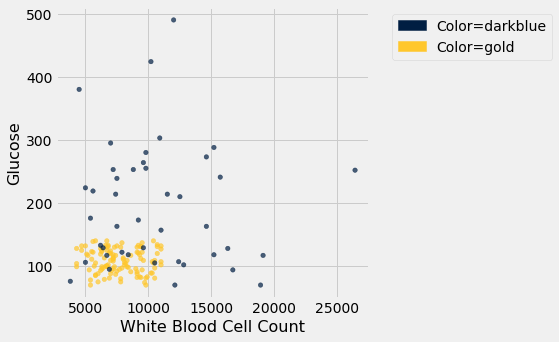

In [57]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

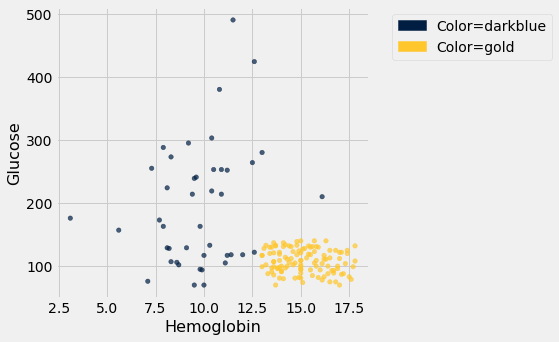

In [58]:
ckd.scatter('Hemoglobin', 'Glucose', group='Color')

In [59]:
# we want to be able to predict the class of someone
# without having to plot & eye ball this graph every time.
#
# one way to do this is to put some thresholds into code

max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

In [60]:
def classify(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

In [61]:
# Let's try our classifier!
classify(15, 100)

0

In [62]:
classify(10, 300)

1

# Google Science Fair

In [63]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [64]:
patients.group('Class')

Class,count
0,444
1,239


In [65]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
patients = patients.join('Class', color_table)

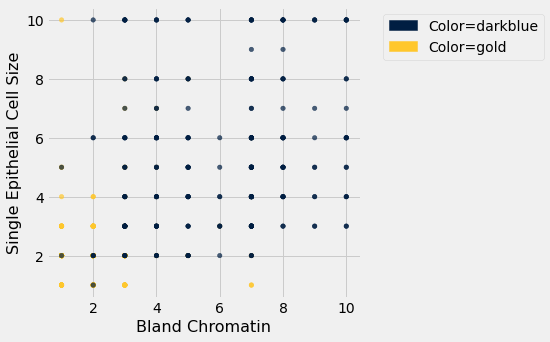

In [66]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Color')

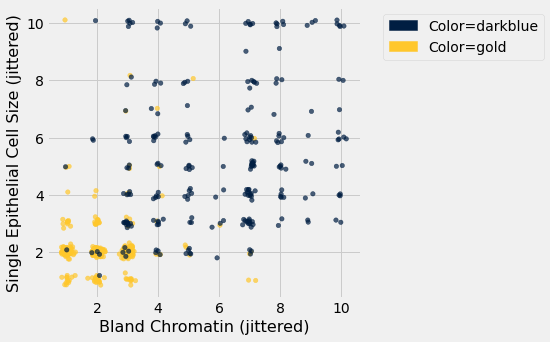

In [67]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Color',
        patients.column('Color')
    ])

jittered.scatter(0, 1, group='Color')

## Distance ##

In [68]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

In [69]:
def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [71]:
attributes = patients.drop('Color')
attributes.show(3)

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,5,1,1,1,2,1,3,1,1
0,5,4,4,5,7,10,3,2,1
0,3,1,1,1,2,2,3,1,1


In [72]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [73]:
row_distance(attributes.row(0), attributes.row(2))

2.23606797749979

In [74]:
row_distance(attributes.row(2), attributes.row(2))

0.0

# The Classifier

In [75]:
def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Color')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    
#   ^ SAME AS DOING:
#
#   for i in np.arange(attributes_only.num_rows):
#       row = attributes_only.row(i)
#       distances = np.append(distances, row_distance(row, example))
        
    return training.with_column('Distance_to_ex', distances)

In [76]:
example = attributes.row(21)
example

Row(Class=0, Clump Thickness=3, Uniformity of Cell Size=1, Uniformity of Cell Shape=1, Marginal Adhesion=1, Single Epithelial Cell Size=1, Bare Nuclei=1, Bland Chromatin=2, Normal Nucleoli=1, Mitoses=1)

In [77]:
distances(patients.exclude(21), example).sort('Distance_to_ex')

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Color,Distance_to_ex
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,2,1,2,1,1,gold,1
0,3,2,1,1,1,1,2,1,1,gold,1
0,3,1,1,1,2,1,2,1,1,gold,1
0,3,1,1,1,2,1,2,1,1,gold,1
0,3,1,1,1,2,1,2,1,1,gold,1
0,3,1,1,1,2,1,2,1,1,gold,1


In [78]:
def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

In [79]:
closest(patients.exclude(21), example, 5)

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Color,Distance_to_ex
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,1,1,2,1,1,gold,0
0,3,1,1,1,2,1,2,1,1,gold,1


In [80]:
closest(patients.exclude(21), example, 5).group('Class').sort('count', descending=True)

Class,count
0,5


In [81]:
def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

In [82]:
def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

In [83]:
classify(patients.exclude(21), example, 5)

0

In [84]:
patients.take(21)

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Color
0,3,1,1,1,1,1,2,1,1,gold


In [85]:
new_example = attributes.row(10)
classify(patients.exclude(10), new_example, 5)

0

In [86]:
patients.take(10)

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Color
0,2,1,1,1,2,1,2,1,1,gold


In [87]:
another_example = attributes.row(15)
classify(patients.exclude(15), another_example, 5)

0

In [88]:
patients.take(15)

Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Color
0,3,1,1,1,2,1,2,1,1,gold


## Review of the Steps ##

- `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
- `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
- `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
- `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
- `majority_class(topk)`: Returns the majority class in the `'Class'` column
- `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Accuracy of a Classifier ##

In [89]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.num_rows

683

In [101]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [94]:
def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    return training.with_column('Distance_to_ex', distances)
def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))
def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)
def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

In [95]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    num_correct = 0
    test_attrs = test.drop("Class")
    for i in np.arange(test.num_rows):
        c = classify(training, test_attrs.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [96]:
training_set

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
6,10,10,10,8,10,10,10,7,1
3,1,2,1,2,1,2,1,1,0
1,1,1,1,1,1,3,1,1,0
6,10,2,8,10,2,7,8,10,1
2,1,1,2,2,1,3,1,1,0
4,1,1,1,2,1,3,1,1,0
6,3,2,1,3,4,4,1,1,1
3,1,1,1,2,1,2,1,1,0
1,1,1,1,1,1,1,1,1,0
7,3,2,10,5,10,5,4,4,1


In [102]:
evaluate_accuracy(training_set, test_set, 5)

0.9706744868035191

In [103]:
evaluate_accuracy(training_set, test_set, 3)

0.9618768328445748

In [104]:
evaluate_accuracy(training_set, test_set, 11)

0.9648093841642229

In [105]:
evaluate_accuracy(training_set, test_set, 1)

0.9442815249266863

# Standardize if Necessary

In [106]:
def standard_units(x):
    return (x - np.average(x)) / np.std(x)

In [107]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = ckd.select('Class','Glucose','Hemoglobin','White Blood Cell Count')

In [108]:
ckd_new = ckd.select('Class').with_columns(
    'Glucose_su', standard_units(ckd.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd.column('Hemoglobin')),
    'WBC_su', standard_units(ckd.column('White Blood Cell Count'))
)

In [109]:
ckd_new

Class,Glucose_su,Hemoglobin_su,WBC_su
1,-0.221549,-0.865744,-0.569768
1,-0.947597,-1.45745,1.16268
1,3.84123,-1.00497,-1.27558
1,0.396364,-2.81488,0.809777
1,0.643529,-2.08395,0.232293
1,-0.561402,-1.35303,-0.505603
1,2.04928,-0.413266,0.360623
1,-0.947597,-1.28342,3.34429
1,1.87936,-1.10939,-0.409356
1,0.489051,-1.35303,1.96475


In [110]:
shuffled = ckd_new.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

In [111]:
evaluate_accuracy(training_set, test_set, 3)

0.972972972972973

In [112]:
shuffled = ckd.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

In [113]:
evaluate_accuracy(training_set, test_set, 3)

0.7837837837837838

In [116]:
ckd_new

Class,Glucose_su,Hemoglobin_su,WBC_su
1,-0.221549,-0.865744,-0.569768
1,-0.947597,-1.45745,1.16268
1,3.84123,-1.00497,-1.27558
1,0.396364,-2.81488,0.809777
1,0.643529,-2.08395,0.232293
1,-0.561402,-1.35303,-0.505603
1,2.04928,-0.413266,0.360623
1,-0.947597,-1.28342,3.34429
1,1.87936,-1.10939,-0.409356
1,0.489051,-1.35303,1.96475
